In [1]:
import torch 
import torch.nn as nn
from dataloader import RetinopathyLoader
from torch.utils.data import  DataLoader
from torchvision import datasets, models, transforms



/home/haha/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class BottleneckBlock(nn.Module):
    """
    output = (channels * 4, H, W) -> conv2d (1x1) -> (channels, H, W) -> conv2d (3x3) -> (channels, H, W)
             -> conv2d (1x1) -> (channels * 4, H, W) + (channels * 4, H, W)
    """
    expansion: int = 4

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, down_sample= None):
        super(BottleneckBlock, self).__init__()

        external_channels = out_channels * self.expansion
        self.activation = nn.ReLU(inplace=True)
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=1,
                      bias=False),
            nn.BatchNorm2d(out_channels),
            self.activation,
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=stride,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(out_channels),
            self.activation,
            nn.Conv2d(in_channels=out_channels,
                      out_channels=external_channels,
                      kernel_size=1,
                      bias=False),
            nn.BatchNorm2d(external_channels),
        )
        self.down_sample = down_sample

    def forward(self, inputs) :
        """
        Forward propagation
        :param inputs: input data
        :return: results
        """
        residual = inputs
        outputs = self.block(inputs)
        if self.down_sample is not None:
            residual = self.down_sample(inputs)

        outputs = self.activation(outputs + residual)

        return outputs

In [3]:
class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.current_channels = 64
        self.conv_1 = nn.Sequential(
                nn.Conv2d(
                    in_channels=3,
                    out_channels=64,
                    kernel_size=7,
                    stride=2,
                    padding=3,
                    bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3,
                             stride=2,
                             padding=1)
            )
        self.conv_2 = self.make_layer(block=block,
                                          num_of_blocks=layers[0],
                                          in_channels=64)
        self.conv_3 = self.make_layer(block=block,
                                          num_of_blocks=layers[1],
                                          in_channels=128,
                                          stride=2)
        self.conv_4 = self.make_layer(block=block,
                                          num_of_blocks=layers[2],
                                          in_channels=256,
                                          stride=2)
        self.conv_5 = self.make_layer(block=block,
                                          num_of_blocks=layers[3],
                                          in_channels=512,
                                          stride=2)
        self.classify = nn.Sequential(
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Flatten(),
                nn.Linear(in_features=512 * block.expansion, out_features=50),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.25),
                nn.Linear(in_features=50, out_features=5)
            )
    def make_layer(self,block,num_of_blocks,in_channels,stride=1):
        down_sample = None
        if ( stride != 1 or self.current_channels != in_channels * block.expansion):
            down_sample = nn.Sequential(
                nn.Conv2d(in_channels=self.current_channels,
                          out_channels=in_channels * block.expansion,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(in_channels * block.expansion),
            )
        layers = [
            block(in_channels=self.current_channels,
                  out_channels=in_channels,
                  stride=stride,
                  down_sample=down_sample)
        ]
        self.current_channels = in_channels * block.expansion
        layers += [block(in_channels=self.current_channels, out_channels=in_channels) for _ in range(1, num_of_blocks)]
        return nn.Sequential(*layers)
    def forward(self,x):
        x=self.conv_1(x)
        x=self.conv_2(x)
        x=self.conv_3(x)
        x=self.conv_4(x)
        x=self.conv_5(x)
        x=self.classify(x)
        return x



In [2]:
def resnet50():
    return ResNet( block=BottleneckBlock, layers=[3, 4, 6, 3])
def resnet18():
    return ResNet(block=BottleneckBlock,layers=[2,2,2,2])

In [2]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

res18_pt=models.resnet18(pretrained=True)
res18_pt.fc=nn.Linear(512,5)
res18_pt.to(device)
#summary(res18_pt,(3,512,512))
res50_pt=models.resnet50(pretrained=True)

res50_pt.fc=nn.Linear(2048,5)
res50_pt.to(device)

res18_npt=models.resnet18(pretrained=False)
res18_npt.fc=nn.Linear(512,5)
res18_npt.to(device)
res50_npt=models.resnet50(pretrained=False)
res50_npt.fc=nn.Linear(2048,5)
res50_npt.to(device)

res50_npt.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
train_dataset = RetinopathyLoader('./data', 'train', [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=10)
    ])
test_dataset=RetinopathyLoader('./data','test')
train_loader = DataLoader(train_dataset, batch_size=16,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)




> Found 28099 images...
> Found 7025 images...


In [4]:
def test_accuracy(net,testloader):
    net.eval()
    accuracy=0
    for x,label in testloader:
        x=x.to(device)
        label=label.to(device).long()
        output=net(x)
        _,Predicted=torch.max(output,1)
        accuracy+=(Predicted==label).sum().item()
        
    return accuracy

In [5]:
EPOCHS=10
def traning(model,epoch=EPOCHS,lr=1e-3):
    model.to(device)
    error_list=[]
    test_acc=[]
    train_acc=[]
    model_optimizer=torch.optim.SGD(model.parameters(),lr=lr,momentum=0.9,weight_decay=5e-4)
    loss_func=nn.CrossEntropyLoss()
    n_total_steps=len(train_loader)
    
    for i in range(epoch):
        torch.cuda.empty_cache()
        accuracy=0
        for step,(data, label) in enumerate(train_loader):
            inputs = data.to(device)
            labels = label.to(device).long().view(-1)
            pred_labels = model.forward(inputs)
            model_optimizer.zero_grad()
            loss = loss_func(pred_labels, labels)
            loss.backward()
            model_optimizer.step()
            _,predicted=torch.max(pred_labels.data,1)
            accuracy+=(predicted==labels).sum().item()
            if (step%100==0):
                print(f' epoch {i+1}, iteration {step+1}/{n_total_steps}, loss = {loss.item():.4f},accruacy={accuracy}')

        test_acc.append(test_accuracy(model,test_loader))
        error_list.append(loss.item())
        print('testacc:',test_accuracy(model,test_loader))
        train_acc.append(accuracy)
            
        
    return error_list,test_acc,train_acc



In [6]:
error_list,test_acc,train_acc=traning(res18_pt)


 epoch 1, iteration 1/1757, loss = 1.8275,accruacy=3
 epoch 1, iteration 101/1757, loss = 1.2831,accruacy=1152
 epoch 1, iteration 201/1757, loss = 1.1160,accruacy=2356
 epoch 1, iteration 301/1757, loss = 0.7785,accruacy=3550
 epoch 1, iteration 401/1757, loss = 0.7808,accruacy=4746
 epoch 1, iteration 501/1757, loss = 0.5780,accruacy=5933
 epoch 1, iteration 601/1757, loss = 0.3744,accruacy=7138
 epoch 1, iteration 701/1757, loss = 0.7148,accruacy=8353
 epoch 1, iteration 801/1757, loss = 1.1683,accruacy=9521
 epoch 1, iteration 901/1757, loss = 0.5983,accruacy=10695
 epoch 1, iteration 1001/1757, loss = 0.8578,accruacy=11915
 epoch 1, iteration 1101/1757, loss = 1.0656,accruacy=13191
 epoch 1, iteration 1201/1757, loss = 0.4143,accruacy=14413
 epoch 1, iteration 1301/1757, loss = 0.6834,accruacy=15617
 epoch 1, iteration 1401/1757, loss = 0.6786,accruacy=16859
 epoch 1, iteration 1501/1757, loss = 0.5086,accruacy=18081
 epoch 1, iteration 1601/1757, loss = 0.5300,accruacy=19333
 epo

In [8]:
error_list2,test_acc2,train_acc2=traning(res18_npt,lr=1e-2)

 epoch 1, iteration 1/1757, loss = 1.7122,accruacy=0
 epoch 1, iteration 101/1757, loss = 0.7774,accruacy=1146
 epoch 1, iteration 201/1757, loss = 1.0851,accruacy=2292
 epoch 1, iteration 301/1757, loss = 1.4327,accruacy=3431
 epoch 1, iteration 401/1757, loss = 0.9888,accruacy=4619
 epoch 1, iteration 501/1757, loss = 0.6678,accruacy=5792
 epoch 1, iteration 601/1757, loss = 1.0728,accruacy=6971
 epoch 1, iteration 701/1757, loss = 1.1178,accruacy=8151
 epoch 1, iteration 801/1757, loss = 0.7939,accruacy=9356
 epoch 1, iteration 901/1757, loss = 0.6029,accruacy=10559
 epoch 1, iteration 1001/1757, loss = 0.9580,accruacy=11719
 epoch 1, iteration 1101/1757, loss = 0.8005,accruacy=12873
 epoch 1, iteration 1201/1757, loss = 0.9936,accruacy=14022
 epoch 1, iteration 1301/1757, loss = 0.9641,accruacy=15182
 epoch 1, iteration 1401/1757, loss = 0.8353,accruacy=16383
 epoch 1, iteration 1501/1757, loss = 0.9148,accruacy=17567
 epoch 1, iteration 1601/1757, loss = 0.8577,accruacy=18751
 epo

In [6]:
res50err,res50test,res50train=traning(res50_pt)


 epoch 1, iteration 1/7025, loss = 1.3743,accruacy=3
 epoch 1, iteration 101/7025, loss = 0.6578,accruacy=302
 epoch 1, iteration 201/7025, loss = 1.2789,accruacy=586
 epoch 1, iteration 301/7025, loss = 0.2577,accruacy=849
 epoch 1, iteration 401/7025, loss = 0.6749,accruacy=1132
 epoch 1, iteration 501/7025, loss = 1.0093,accruacy=1419
 epoch 1, iteration 601/7025, loss = 0.1889,accruacy=1733
 epoch 1, iteration 701/7025, loss = 0.2756,accruacy=2030
 epoch 1, iteration 801/7025, loss = 0.2850,accruacy=2319
 epoch 1, iteration 901/7025, loss = 1.3299,accruacy=2620
 epoch 1, iteration 1001/7025, loss = 0.9773,accruacy=2919
 epoch 1, iteration 1101/7025, loss = 0.3101,accruacy=3213
 epoch 1, iteration 1201/7025, loss = 0.3384,accruacy=3508
 epoch 1, iteration 1301/7025, loss = 0.8887,accruacy=3812
 epoch 1, iteration 1401/7025, loss = 0.4374,accruacy=4108
 epoch 1, iteration 1501/7025, loss = 1.7778,accruacy=4402
 epoch 1, iteration 1601/7025, loss = 0.7072,accruacy=4700
 epoch 1, itera

In [7]:
res50err2,res50test2,res50train2=traning(res50_npt,epoch=10,lr=5e-3)

 epoch 1, iteration 1/7025, loss = 1.7163,accruacy=2
 epoch 1, iteration 101/7025, loss = 1.2769,accruacy=242
 epoch 1, iteration 201/7025, loss = 1.3043,accruacy=524
 epoch 1, iteration 301/7025, loss = 2.3153,accruacy=796
 epoch 1, iteration 401/7025, loss = 1.2472,accruacy=1068
 epoch 1, iteration 501/7025, loss = 1.7220,accruacy=1350
 epoch 1, iteration 601/7025, loss = 1.5043,accruacy=1644
 epoch 1, iteration 701/7025, loss = 1.7919,accruacy=1935
 epoch 1, iteration 801/7025, loss = 1.0334,accruacy=2214
 epoch 1, iteration 901/7025, loss = 0.1176,accruacy=2509
 epoch 1, iteration 1001/7025, loss = 2.1385,accruacy=2803
 epoch 1, iteration 1101/7025, loss = 0.6795,accruacy=3110
 epoch 1, iteration 1201/7025, loss = 1.0731,accruacy=3389
 epoch 1, iteration 1301/7025, loss = 2.1356,accruacy=3682
 epoch 1, iteration 1401/7025, loss = 0.3308,accruacy=3981
 epoch 1, iteration 1501/7025, loss = 0.4600,accruacy=4273
 epoch 1, iteration 1601/7025, loss = 1.4427,accruacy=4566
 epoch 1, itera

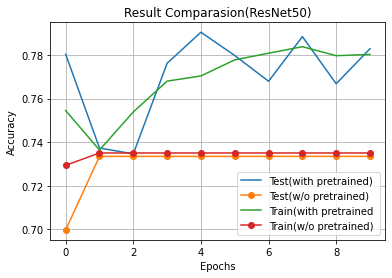

TEST MAX accuracy: 0.7904626334519573


In [8]:
import matplotlib.pyplot as plt
import numpy as np
res50test2=np.array(res50test2)
res50test=np.array(res50test)
res50train2=np.array(res50train2)
res50train=np.array(res50train)
new_res50test2=res50test2/7025
new_res50test=res50test/7025
new_res50train2=res50train2/28099
new_res50train=res50train/28099
plt.title('Result Comparasion(ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(range(10),new_res50test,label='Test(with pretrained) ')
plt.plot(range(10),new_res50test2,marker='o',label='Test(w/o pretrained) ')

plt.plot(range(10),new_res50train,label='Train(with pretrained ')
plt.plot(range(10),new_res50train2,marker='o',label='Train(w/o pretrained) ')
plt.legend()
plt.grid()
plt.show()
print('TEST MAX accuracy:',max(new_res50test)*100,'%')

max accuracy 81.02491103202847 %


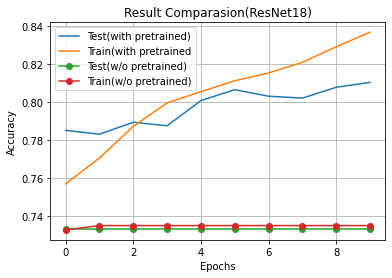

In [9]:
import matplotlib.pyplot as plt
import numpy as np

test_acc=np.array(test_acc)
train_acc=np.array(train_acc)
new_train_acc=train_acc/28099
new_test_acc=test_acc/7025
test_acc2=np.array( test_acc2)
train_acc2=np.array(train_acc2)
new_test_acc2=test_acc2/7025
new_train_acc2=train_acc2/28099
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Result Comparasion(ResNet18)')
plt.plot(range(10),new_test_acc,label='Test(with pretrained)')
plt.plot(range(10),new_train_acc,label='Train(with pretrained')

plt.plot(range(10),new_test_acc2,marker='o',label='Test(w/o pretrained)')
plt.plot(range(10),new_train_acc2,marker='o',label='Train(w/o pretrained)')
plt.legend()
plt.grid()
print('max accuracy',max(new_test_acc)*100,'%')

In [11]:
from sklearn.metrics import confusion_matrix
def makeconfusionmatrix(model):
    y_pred = []
    y_true = []
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        for i, (images, target) in enumerate(test_loader):
            images=images.to(device)
            target=target.to(device)
            output = model(images)
            _, preds = torch.max(output, 1) 
            y_pred.extend(preds.view(-1).detach().cpu().numpy())       
            y_true.extend(target.view(-1).detach().cpu().numpy())
            print(i,'/',len(test_loader))
    cf_matrix = confusion_matrix(y_true, y_pred)
    cf_matrix_normalize=confusion_matrix(y_true,y_pred,normalize='true')
    return cf_matrix,cf_matrix_normalize

In [17]:
upres50confuse,upres50conffusenor=makeconfusionmatrix(res18_pt)

0 / 1757
1 / 1757
2 / 1757
3 / 1757
4 / 1757
5 / 1757
6 / 1757
7 / 1757
8 / 1757
9 / 1757
10 / 1757
11 / 1757
12 / 1757
13 / 1757
14 / 1757
15 / 1757
16 / 1757
17 / 1757
18 / 1757
19 / 1757
20 / 1757
21 / 1757
22 / 1757
23 / 1757
24 / 1757
25 / 1757
26 / 1757
27 / 1757
28 / 1757
29 / 1757
30 / 1757
31 / 1757
32 / 1757
33 / 1757
34 / 1757
35 / 1757
36 / 1757
37 / 1757
38 / 1757
39 / 1757
40 / 1757
41 / 1757
42 / 1757
43 / 1757
44 / 1757
45 / 1757
46 / 1757
47 / 1757
48 / 1757
49 / 1757
50 / 1757
51 / 1757
52 / 1757
53 / 1757
54 / 1757
55 / 1757
56 / 1757
57 / 1757
58 / 1757
59 / 1757
60 / 1757
61 / 1757
62 / 1757
63 / 1757
64 / 1757
65 / 1757
66 / 1757
67 / 1757
68 / 1757
69 / 1757
70 / 1757
71 / 1757
72 / 1757
73 / 1757
74 / 1757
75 / 1757
76 / 1757
77 / 1757
78 / 1757
79 / 1757
80 / 1757
81 / 1757
82 / 1757
83 / 1757
84 / 1757
85 / 1757
86 / 1757
87 / 1757
88 / 1757
89 / 1757
90 / 1757
91 / 1757
92 / 1757
93 / 1757
94 / 1757
95 / 1757
96 / 1757
97 / 1757
98 / 1757
99 / 1757
100 / 1757

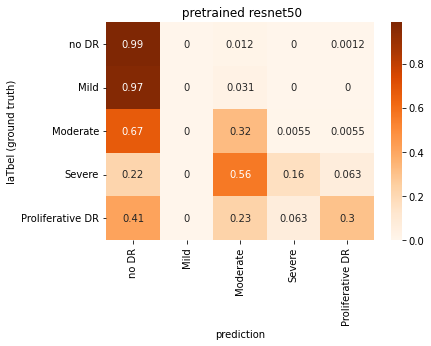

In [23]:

import pandas as pd
import seaborn as sns
def plot_confusion_matrix(cf_matrix,name):
    class_names = ['no DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
    df_cm = pd.DataFrame(cf_matrix, class_names, class_names) 
    sns.heatmap(df_cm, annot=True, cmap='Oranges')
    plt.title(name)
    plt.xlabel("prediction")
    plt.ylabel("laTbel (ground truth)")


plot_confusion_matrix(upres50conffusenor,' pretrained resnet50')


In [10]:
maxacc=test_accuracy(res18_pt,test_loader)/7025

In [12]:
print('maxaccuracy',maxacc*100,'%')

maxaccuracy 81.02491103202847 %
